## Data Preprocessing


In [118]:
import uuid
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from skimage.morphology import skeletonize
import imutils

import cv2
import os
import numpy as np
import uuid
import logging
import matplotlib.pyplot as plt

IMG_SIZE = (64, 64)


def show(img):
    plt.imshow(img)
    plt.show()


def remove_lines(img):
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([50, 50, 50])  # Adjust as needed based on line intensity
    mask = cv2.inRange(img, lower_black, upper_black)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_inpainted = cv2.inpaint(gray, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return img_inpainted


def crop(img):
    _, thresh = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY_INV)
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    cropped_image = img[y : y + h, x : x + w]
    return cropped_image


def remove_noise(img):
    """
    Removes noise from the image using a combination of morphological operations
    and filtering techniques.
    """
    # Convert to grayscale and invert
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    inverted = cv2.bitwise_not(gray)

    # Initial erosion to weaken noise
    kernel = np.ones((2, 2), np.uint8)
    eroded = cv2.erode(inverted, kernel, iterations=1)

    # Median filtering to remove lines and circles
    vertical_filtered = cv2.medianBlur(eroded, 5)  # Vertical filter
    horizontal_filtered = cv2.medianBlur(vertical_filtered, 3)  # Horizontal filter

    # Dilate to restore characters
    dilated = cv2.dilate(horizontal_filtered, kernel, iterations=1)

    # Final median filter to clean up
    cleaned = cv2.medianBlur(dilated, 3)

    # Remove remaining circles using Hough transform
    circles = cv2.HoughCircles(
        cleaned,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=1,
        param1=50,
        param2=30,
        minRadius=0,
        maxRadius=2,
    )

    if circles is not None:
        circles = np.uint16(np.around(circles))
        mask = np.ones_like(cleaned)
        for i in circles[0, :]:
            cv2.circle(mask, (i[0], i[1]), i[2], 0, -1)
        cleaned = cleaned * mask

    # Final morphological operations
    kernel = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(cleaned, kernel, iterations=1)
    vertical_filtered = cv2.medianBlur(eroded, 5)
    dilated = cv2.dilate(vertical_filtered, kernel, iterations=2)
    final = cv2.erode(dilated, kernel, iterations=1)

    return final


# def segment_characters(img):
#     """
#     Segments characters using connected components and watershed algorithm.
#     Returns a list of character images.
#     """
#     # Find connected components
#     num_labels, labels = cv2.connectedComponents(img)

#     # Initialize markers for watershed
#     markers = np.zeros(img.shape, dtype=np.int32)

#     # Process components
#     char_regions = []
#     for label in range(1, num_labels):
#         mask = (labels == label).astype(np.uint8) * 255
#         pixel_count = np.sum(mask > 0)

#         # Filter out noise (too small) and handle joint characters (too large)
#         if pixel_count < 100:  # Noise
#             continue
#         elif pixel_count >= 2200:  # Joint characters
#             # Split into two characters
#             h, w = mask.shape
#             left_mask = mask[:, : w // 2]
#             right_mask = mask[:, w // 2 :]
#             char_regions.extend([left_mask, right_mask])
#         else:
#             char_regions.append(mask)

#     # Ensure exactly 4 characters
#     if len(char_regions) != 4:
#         return None

#     # Squarify characters
#     squared_chars = []
#     target_size = (76, 76)
#     for char in char_regions:
#         h, w = char.shape

#         # Create square background
#         square = np.zeros(target_size, dtype=np.uint8)

#         # Calculate padding
#         pad_top = (target_size[0] - h) // 2
#         pad_left = (target_size[1] - w) // 2

#         # Place character in center
#         square[pad_top : pad_top + h, pad_left : pad_left + w] = char
#         squared_chars.append(square)

#     return squared_chars


# def preprocess_captcha(img):
#     """
#     Main preprocessing function that combines noise removal and character segmentation.
#     """
#     # Remove noise
#     cleaned = remove_noise(img)

#     # Segment characters
#     characters = segment_characters(cleaned)

#     return characters


# def preprocess_image(img):
#     """
#     Preprocesses an image through binarization, denoising, and thinning.

#     Args:
#         img: Input image (BGR or grayscale)

#     Returns:
#         numpy.ndarray: Preprocessed binary image
#     """
#     # Convert to grayscale if not already
#     if len(img.shape) == 3:
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     else:
#         gray = img.copy()

#     # Step 1: Binarization using Otsu's method
#     # Otsu automatically determines optimal threshold value
#     _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

#     # Step 2: Denoising
#     # First apply median blur to remove salt-and-pepper noise
#     denoised = cv2.medianBlur(binary, 3)
#     # Then use morphological opening to remove small noise and smooth edges
#     kernel = np.ones((3, 3), np.uint8)
#     denoised = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, kernel)

#     # Step 3: Thinning
#     # Convert to boolean array for skeletonization
#     binary_for_skeleton = denoised > 0
#     skeleton = skeletonize(binary_for_skeleton)

#     # Convert back to uint8 format (0-255)
#     result = (skeleton * 255).astype(np.uint8)

#     return result


def segment_save(img, filename, destination_path):
    # Get the correct characters from filename
    captcha_contents = filename.split("-")[0]
    chars = list(captcha_contents)

    # Create character directories if they don't exist
    for char in chars:
        class_path = os.path.join(destination_path, char)
        if not os.path.exists(class_path):
            os.makedirs(class_path)

    height, width = img.shape
    num_portions = len(chars)
    portion_width = width // num_portions

    for i in range(num_portions):
        # Segment
        x_start = i * portion_width
        x_end = x_start + portion_width
        portion = img[:, x_start:x_end]

        # Resize (keras will do it for us apparently)
        portion = cv2.resize(portion, IMG_SIZE, interpolation=cv2.INTER_AREA)

        # Threshold the image to make sure everything is black and white
        _, portion = cv2.threshold(portion, 240, 255, cv2.THRESH_BINARY_INV)

        # Save
        char_filename = f"{chars[i]}/{chars[i]}_0.png"
        char_filepath = os.path.join(destination_path, char_filename)
        counter = 0
        while os.path.exists(char_filepath):
            char_filename = f"{chars[i]}/{chars[i]}_{counter}.png"
            char_filepath = os.path.join(destination_path, char_filename)
            counter += 1
        cv2.imwrite(char_filepath, portion)


# def segment_save_better(img, filename, destination_path):
#     """
#     Segments and saves individual characters from a captcha image using contour detection.

#     Args:
#         img: Grayscale input image
#         filename: Original filename containing the captcha text
#         destination_path: Path to save the segmented characters
#     """
#     # Get the correct characters from filename
#     captcha_contents = filename.split("-")[0]
#     chars = list(captcha_contents)

#     # Create character directories if they don't exist
#     for char in chars:
#         class_path = os.path.join(destination_path, char)
#         if not os.path.exists(class_path):
#             os.makedirs(class_path)

#     # Get image dimensions and calculate portions
#     height, width = img.shape
#     num_portions = len(chars)
#     portion_width = width // num_portions

#     # Since the input image is already grayscale, no need to convert
#     gray = img

#     # Add padding around the image
#     gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

#     # threshold the image (convert it to pure black and white)
#     thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

#     # find the contours (continuous blobs of pixels) the image
#     contours = cv2.findContours(
#         thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
#     )

#     # Hack for compatibility with different OpenCV versions
#     contours = contours[1] if imutils.is_cv3() else contours[0]

#     letter_image_regions = []

#     # If contour detection fails, fall back to simple division method
#     if len(contours) != len(chars):
#         for i in range(num_portions):
#             # Segment
#             x_start = i * portion_width
#             x_end = x_start + portion_width
#             portion = img[:, x_start:x_end]

#             # Ensure portion is not empty
#             if portion.size == 0:
#                 continue

#             # Resize
#             portion = cv2.resize(portion, IMG_SIZE, interpolation=cv2.INTER_AREA)

#             # Threshold
#             _, portion = cv2.threshold(portion, 240, 255, cv2.THRESH_BINARY_INV)

#             # Save
#             counter = 0
#             while True:
#                 char_filename = f"{chars[i]}/{chars[i]}_{counter}.png"
#                 char_filepath = os.path.join(destination_path, char_filename)
#                 if not os.path.exists(char_filepath):
#                     cv2.imwrite(char_filepath, portion)
#                     break
#                 counter += 1
#         return

#     # Sort contours left-to-right
#     contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

#     # Process each contour
#     for contour in contours:
#         x, y, w, h = cv2.boundingRect(contour)

#         # Compare the width and height of the contour to detect letters that
#         # are conjoined into one chunk
#         if w / h > 1.25:
#             # This contour is too wide to be a single letter!
#             # Split it in half into two letter regions!
#             half_width = int(w / 2)
#             letter_image_regions.append((x, y, half_width, h))
#             letter_image_regions.append((x + half_width, y, half_width, h))
#         else:
#             # This is a normal letter by itself
#             letter_image_regions.append((x, y, w, h))

#     # If we found more or less than the expected number of letters, skip the image
#     if len(letter_image_regions) != len(chars):
#         return

#     # Sort the detected letter images based on the x coordinate
#     letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

#     # Save out each letter as a single image
#     for letter_bounding_box, letter_text in zip(letter_image_regions, chars):
#         x, y, w, h = letter_bounding_box

#         # Extract the letter from the original image with a 2-pixel margin around the edge
#         letter_image = gray[y - 2 : y + h + 2, x - 2 : x + w + 2]

#         # Ensure the letter image is not empty before resizing
#         if letter_image.size == 0:
#             continue

#         # Resize
#         letter_image = cv2.resize(letter_image, IMG_SIZE, interpolation=cv2.INTER_AREA)

#         # Threshold
#         _, letter_image = cv2.threshold(letter_image, 240, 255, cv2.THRESH_BINARY_INV)

#         # Save
#         counter = 0
#         while True:
#             char_filename = f"{letter_text}/{letter_text}_{counter}.png"
#             char_filepath = os.path.join(destination_path, char_filename)
#             if not os.path.exists(char_filepath):
#                 cv2.imwrite(char_filepath, letter_image)
#                 break
#             counter += 1


# def preprocess_image(img):
#     """Apply preprocessing steps to the image."""
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img.copy()
#     gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
#     thresh = cv2.adaptiveThreshold(
#         gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
#     )
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
#     thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
#     return thresh


# def get_letter_regions(thresh, num_chars):
#     """Detect and return letter regions from the thresholded image."""
#     num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
#         thresh, connectivity=8
#     )
#     letter_image_regions = []
#     for i in range(1, num_labels):
#         x, y, w, h, area = stats[i]
#         aspect_ratio = w / float(h)
#         if area < 100 or aspect_ratio < 0.2 or aspect_ratio > 1.0:
#             continue
#         if aspect_ratio > 0.7:
#             half_width = int(w / 2)
#             letter_image_regions.append((x, y, half_width, h))
#             letter_image_regions.append((x + half_width, y, half_width, h))
#         else:
#             letter_image_regions.append((x, y, w, h))
#     if len(letter_image_regions) != num_chars:
#         return None
#     letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
#     return letter_image_regions


# def save_letters(gray, regions, chars, destination_path):
#     """Save individual letter images."""
#     for (x, y, w, h), char in zip(regions, chars):
#         letter_image = gray[y - 2 : y + h + 2, x - 2 : x + w + 2]
#         if letter_image.size == 0:
#             continue
#         letter_image = cv2.resize(letter_image, IMG_SIZE, interpolation=cv2.INTER_AREA)
#         _, letter_image = cv2.threshold(letter_image, 240, 255, cv2.THRESH_BINARY_INV)
#         unique_id = uuid.uuid4().hex
#         char_filename = f"{char}/{char}_{unique_id}.png"
#         char_filepath = os.path.join(destination_path, char_filename)
#         cv2.imwrite(char_filepath, letter_image)


# def segment_save_better(img, filename, destination_path):
#     """
#     Segments and saves individual characters from a captcha image using contour detection.

#     Args:
#         img: Grayscale input image
#         filename: Original filename containing the captcha text
#         destination_path: Path to save the segmented characters
#     """
#     captcha_contents = filename.split("-")[0]
#     chars = list(captcha_contents)

#     # Create directories
#     for char in chars:
#         class_path = os.path.join(destination_path, char)
#         os.makedirs(class_path, exist_ok=True)

#     thresh = preprocess_image(img)
#     letter_regions = get_letter_regions(thresh, len(chars))

#     if letter_regions is None:
#         print(f"Warning: Segmentation failed for {filename}.")
#         # Fallback segmentation method can be implemented here
#         return

#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img.copy()
#     gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
#     save_letters(gray, letter_regions, chars, destination_path)


# def remove_watermark(img):
#     # Convert to grayscale if needed
#     if len(img.shape) == 3:
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     else:
#         gray = img.copy()

#     # Create background model
#     background = cv2.medianBlur(gray, 21)  # Large kernel to capture background

#     # Subtract background
#     foreground = cv2.absdiff(gray, background)

#     # Threshold to get clean text
#     _, thresh = cv2.threshold(foreground, 30, 255, cv2.THRESH_BINARY)

#     # Clean up noise
#     kernel = np.ones((2, 2), np.uint8)
#     cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

#     return cleaned


def print_char_stats(chars_path):
    classes = os.listdir(chars_path)

    # Initialize a counter to track the occurrences of each character
    character_counter = Counter()

    # Loop through each file in the folder
    for folder in classes:
        for char in folder:
            # Make sure the file is a valid image (you can adjust the file extension if needed)
            if char.endswith(".png"):
                # Extract the character label from the filename (assuming filename format like 'a_1.png')
                character_label = char.split("_")[
                    0
                ]  # Adjust based on your filename format

                # Update the counter with the extracted character label
                character_counter[character_label] += 1

    # Total number of characters (images)
    total_characters = sum(character_counter.values())

    # Number of unique classes (characters)
    num_classes = len(classes)

    # Print statistics
    print(f"Total number of characters: {total_characters}")
    print(f"Number of unique classes (characters): {num_classes}")
    print("\nCharacter distribution:")
    for character, count in character_counter.items():
        print(f"Character '{character}': {count} instances")

    return num_classes


# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.FileHandler("segmentation.log"), logging.StreamHandler()],
)

IMG_SIZE = (64, 64)


def visualize_segmentation(img, thresh, regions, filename):
    """Visualize thresholded image and detected regions."""
    # Convert grayscale image to RGB for visualization
    if len(img.shape) == 2:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img_rgb = img.copy()

    # Draw bounding boxes
    for x, y, w, h in regions:
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Plot thresholded image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Thresholded Image: {filename}")
    plt.imshow(thresh, cmap="gray")
    plt.axis("off")

    # Plot image with bounding boxes
    plt.subplot(1, 2, 2)
    plt.title("Detected Regions")
    plt.imshow(img_rgb, cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


def deskew_image(gray):
    """Deskew image based on its moments."""
    coords = np.column_stack(np.where(gray > 0))
    if coords.size == 0:
        logging.warning("No foreground pixels found for deskewing.")
        return gray
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = gray.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed = cv2.warpAffine(
        gray, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )
    logging.info(f"Deskewed image by {angle:.2f} degrees.")
    return deskewed


def preprocess_image(img):
    """Apply preprocessing steps to the image."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img.copy()
    gray = deskew_image(gray)
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    # Adaptive Thresholding
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    # Apply Morphological Operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    return thresh


def get_letter_regions(thresh, num_chars):
    """Detect and return letter regions from the thresholded image."""
    contours, _ = cv2.findContours(
        thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    letter_image_regions = []
    for contour in contours:
        # Approximate the contour to reduce the number of points
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = w / float(h)
        area = cv2.contourArea(contour)
        solidity = area / (w * h)

        if area < 100 or aspect_ratio < 0.2 or aspect_ratio > 1.0 or solidity < 0.4:
            continue
        if aspect_ratio > 0.7:
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            letter_image_regions.append((x, y, w, h))
    if len(letter_image_regions) != num_chars:
        logging.warning(
            f"Detected regions: {len(letter_image_regions)}, Expected: {num_chars}"
        )
        return None
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    return letter_image_regions


def save_letters(gray, regions, chars, destination_path):
    """Save individual letter images."""
    if len(regions) != len(chars):
        logging.warning(
            f"Number of regions ({len(regions)}) does not match number of characters ({len(chars)})."
        )

    for (x, y, w, h), char in zip(regions, chars):
        if w <= 0 or h <= 0:
            logging.warning(
                f"Invalid region dimensions for character '{char}': w={w}, h={h}. Skipping."
            )
            continue
        try:
            letter_image = gray[y - 2 : y + h + 2, x - 2 : x + w + 2]
            if letter_image.size == 0:
                logging.warning(
                    f"Empty image for character '{char}' at region {(x, y, w, h)}. Skipping."
                )
                continue
            letter_image = cv2.resize(
                letter_image, IMG_SIZE, interpolation=cv2.INTER_AREA
            )
            _, letter_image = cv2.threshold(
                letter_image, 240, 255, cv2.THRESH_BINARY_INV
            )
            unique_id = uuid.uuid4().hex
            char_filename = f"{char}/{char}_{unique_id}.png"
            char_filepath = os.path.join(destination_path, char_filename)
            cv2.imwrite(char_filepath, letter_image)
            logging.info(f"Saved character '{char}' to {char_filepath}.")
        except Exception as e:
            logging.error(f"Error saving character '{char}': {e}")


def fallback_segment(img, filename, destination_path):
    """Fallback segmentation method using simple division."""
    logging.info(f"Applying fallback segmentation for {filename}.")
    captcha_contents = filename.split("-")[0]
    chars = list(captcha_contents)
    height, width = img.shape
    num_chars = len(chars)
    portion_width = width // num_chars

    for i in range(num_chars):
        x_start = i * portion_width
        x_end = (i + 1) * portion_width if i < num_chars - 1 else width
        portion = img[:, x_start:x_end]

        # Preprocess portion
        portion = cv2.copyMakeBorder(portion, 2, 2, 2, 2, cv2.BORDER_REPLICATE)
        portion = cv2.resize(portion, IMG_SIZE, interpolation=cv2.INTER_AREA)
        _, portion = cv2.threshold(portion, 240, 255, cv2.THRESH_BINARY_INV)

        # Save
        try:
            unique_id = uuid.uuid4().hex
            char_filename = f"{chars[i]}/{chars[i]}_{unique_id}.png"
            char_filepath = os.path.join(destination_path, char_filename)
            cv2.imwrite(char_filepath, portion)
            logging.info(
                f"Saved character '{chars[i]}' to {char_filepath} using fallback."
            )
        except Exception as e:
            logging.error(f"Error saving character '{chars[i]}' in fallback: {e}")

    logging.info(f"Fallback segmentation completed for {filename}.")


def segment_save_better(img, filename, destination_path):
    """
    Segments and saves individual characters from a captcha image using contour detection.

    Args:
        img: Grayscale input image
        filename: Original filename containing the captcha text
        destination_path: Path to save the segmented characters
    """
    logging.info(f"Processing file: {filename}")
    captcha_contents = filename.split("-")[0]
    chars = list(captcha_contents)

    # Create directories
    for char in chars:
        class_path = os.path.join(destination_path, char)
        os.makedirs(class_path, exist_ok=True)

    thresh = preprocess_image(img)
    letter_regions = get_letter_regions(thresh, len(chars))

    if letter_regions is None:
        logging.warning(f"Segmentation failed for {filename}.")
        # visualize_segmentation(img, thresh, [], filename)
        fallback_segment(img, filename, destination_path)
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img.copy()
    gray = deskew_image(gray)
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    save_letters(gray, letter_regions, chars, destination_path)

    # Visualize successful segmentation
    # visualize_segmentation(gray, thresh, letter_regions, filename)

    logging.info(f"Successfully segmented and saved characters for {filename}.")

In [8]:
folder_path = "./dataset/"  # change this to your dataset folder
main_path = folder_path + "main/"
train_path = folder_path + "train/"
test_path = folder_path + "test/"
train_chars_path = folder_path + "train_chars/"
test_chars_path = folder_path + "test_chars/"

# Small Sample Testing


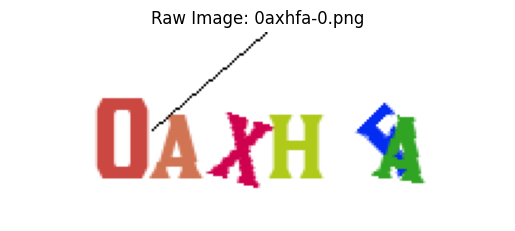

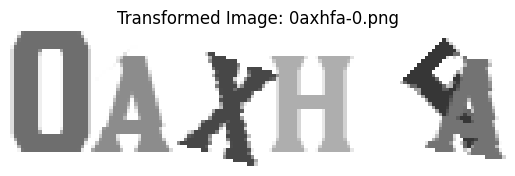

2024-11-13 18:01:52,935 - INFO - Processing file: 0axhfa-0.png
2024-11-13 18:01:52,937 - INFO - Deskewed image by -90.00 degrees.
2024-11-13 18:01:52,937 - WARNING - Detected regions: 0, Expected: 6
2024-11-13 18:01:52,938 - WARNING - Segmentation failed for 0axhfa-0.png.
2024-11-13 18:01:52,938 - INFO - Applying fallback segmentation for 0axhfa-0.png.
2024-11-13 18:01:52,939 - INFO - Saved character '0' to ./dataset/train_segments/0/0_3e4190711b874762b7daa3717b99a729.png using fallback.
2024-11-13 18:01:52,940 - INFO - Saved character 'a' to ./dataset/train_segments/a/a_7d0ac72ffdcf4a28875555f9fbb85566.png using fallback.
2024-11-13 18:01:52,941 - INFO - Saved character 'x' to ./dataset/train_segments/x/x_968a143d5e97433f8e7a9267448f36dd.png using fallback.
2024-11-13 18:01:52,942 - INFO - Saved character 'h' to ./dataset/train_segments/h/h_c16e502cccbb43f79090be12678c6740.png using fallback.
2024-11-13 18:01:52,943 - INFO - Saved character 'f' to ./dataset/train_segments/f/f_6344ac55

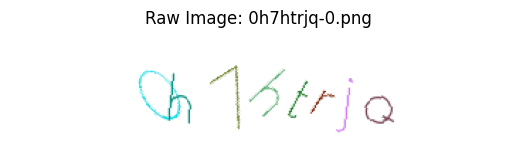

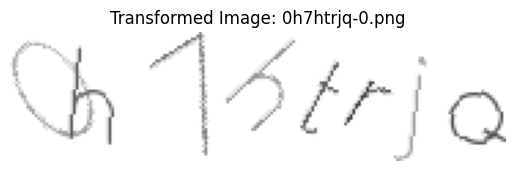

2024-11-13 18:01:53,014 - INFO - Processing file: 0h7htrjq-0.png
2024-11-13 18:01:53,016 - INFO - Deskewed image by -90.00 degrees.
2024-11-13 18:01:53,016 - WARNING - Detected regions: 0, Expected: 8
2024-11-13 18:01:53,017 - WARNING - Segmentation failed for 0h7htrjq-0.png.
2024-11-13 18:01:53,017 - INFO - Applying fallback segmentation for 0h7htrjq-0.png.
2024-11-13 18:01:53,019 - INFO - Saved character '0' to ./dataset/train_segments/0/0_90e3c372d4d84ea2a67a5db10980ed60.png using fallback.
2024-11-13 18:01:53,020 - INFO - Saved character 'h' to ./dataset/train_segments/h/h_94e5fb8322294cc18b0b3ccfb6815e8a.png using fallback.
2024-11-13 18:01:53,021 - INFO - Saved character '7' to ./dataset/train_segments/7/7_2c20759e49344cc4aaeeb0e9101bc4ee.png using fallback.
2024-11-13 18:01:53,022 - INFO - Saved character 'h' to ./dataset/train_segments/h/h_96996bd35fb54b59b4a243e362a9b345.png using fallback.
2024-11-13 18:01:53,023 - INFO - Saved character 't' to ./dataset/train_segments/t/t_5a

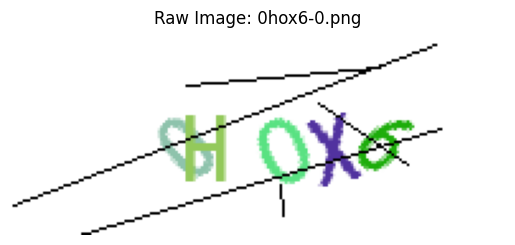

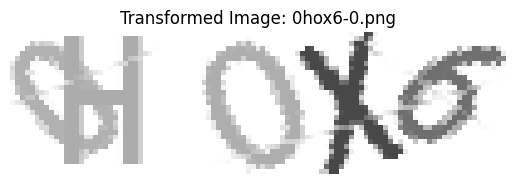

2024-11-13 18:01:53,093 - INFO - Processing file: 0hox6-0.png
2024-11-13 18:01:53,095 - INFO - Deskewed image by -90.00 degrees.
2024-11-13 18:01:53,096 - WARNING - Detected regions: 0, Expected: 5
2024-11-13 18:01:53,096 - WARNING - Segmentation failed for 0hox6-0.png.
2024-11-13 18:01:53,097 - INFO - Applying fallback segmentation for 0hox6-0.png.
2024-11-13 18:01:53,097 - INFO - Saved character '0' to ./dataset/train_segments/0/0_6f81ad17a8cc42e2a2f7c538360fd108.png using fallback.
2024-11-13 18:01:53,098 - INFO - Saved character 'h' to ./dataset/train_segments/h/h_20fee4202e6549b2a65ddfbd8cea57a9.png using fallback.
2024-11-13 18:01:53,099 - INFO - Saved character 'o' to ./dataset/train_segments/o/o_2c7f15049d824167874258251b307db8.png using fallback.
2024-11-13 18:01:53,100 - INFO - Saved character 'x' to ./dataset/train_segments/x/x_b8c43f851d6047e38025d13685a3fade.png using fallback.
2024-11-13 18:01:53,100 - INFO - Saved character '6' to ./dataset/train_segments/6/6_f71e1f5492c

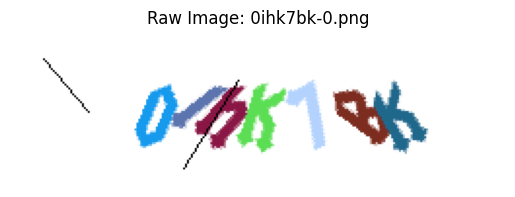

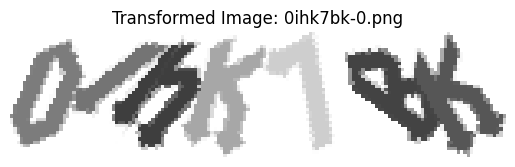

2024-11-13 18:01:53,159 - INFO - Processing file: 0ihk7bk-0.png
2024-11-13 18:01:53,161 - INFO - Deskewed image by -90.00 degrees.
2024-11-13 18:01:53,162 - WARNING - Detected regions: 0, Expected: 7
2024-11-13 18:01:53,162 - WARNING - Segmentation failed for 0ihk7bk-0.png.
2024-11-13 18:01:53,163 - INFO - Applying fallback segmentation for 0ihk7bk-0.png.
2024-11-13 18:01:53,164 - INFO - Saved character '0' to ./dataset/train_segments/0/0_bada810f48744c669fc7481f7826e4a8.png using fallback.
2024-11-13 18:01:53,165 - INFO - Saved character 'i' to ./dataset/train_segments/i/i_270b6d58a22644b4a8bedaee04507a5b.png using fallback.
2024-11-13 18:01:53,166 - INFO - Saved character 'h' to ./dataset/train_segments/h/h_05de7cd46a5942d9b2e5cb10709f5df0.png using fallback.
2024-11-13 18:01:53,167 - INFO - Saved character 'k' to ./dataset/train_segments/k/k_f2f4c5b8adfd45cb93f304da48ea2593.png using fallback.
2024-11-13 18:01:53,168 - INFO - Saved character '7' to ./dataset/train_segments/7/7_f262f

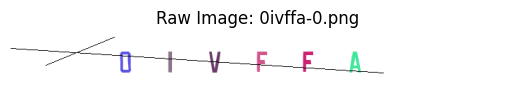

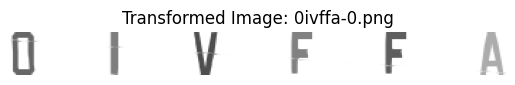

2024-11-13 18:01:53,220 - INFO - Processing file: 0ivffa-0.png
2024-11-13 18:01:53,221 - INFO - Deskewed image by -90.00 degrees.
2024-11-13 18:01:53,221 - WARNING - Detected regions: 0, Expected: 6
2024-11-13 18:01:53,222 - WARNING - Segmentation failed for 0ivffa-0.png.
2024-11-13 18:01:53,222 - INFO - Applying fallback segmentation for 0ivffa-0.png.
2024-11-13 18:01:53,223 - INFO - Saved character '0' to ./dataset/train_segments/0/0_c5ac66625743466fae37aa4c5e9c1cbe.png using fallback.
2024-11-13 18:01:53,223 - INFO - Saved character 'i' to ./dataset/train_segments/i/i_112fdde044284208af47e768f33429c0.png using fallback.
2024-11-13 18:01:53,224 - INFO - Saved character 'v' to ./dataset/train_segments/v/v_51f580b59f8f429d86ab6a6027cfb09f.png using fallback.
2024-11-13 18:01:53,225 - INFO - Saved character 'f' to ./dataset/train_segments/f/f_e9fcd23cffcc4d559de3b32cfe8b4bcd.png using fallback.
2024-11-13 18:01:53,226 - INFO - Saved character 'f' to ./dataset/train_segments/f/f_d2447d09

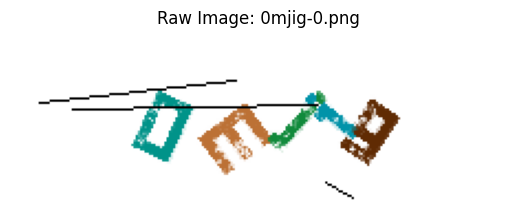

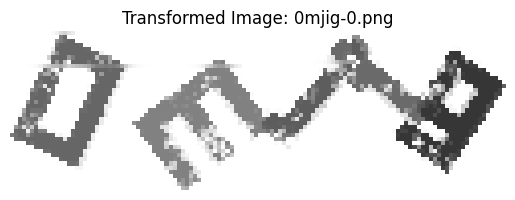

2024-11-13 18:01:53,302 - INFO - Processing file: 0mjig-0.png
2024-11-13 18:01:53,303 - INFO - Deskewed image by -90.00 degrees.
2024-11-13 18:01:53,303 - WARNING - Detected regions: 0, Expected: 5
2024-11-13 18:01:53,304 - WARNING - Segmentation failed for 0mjig-0.png.
2024-11-13 18:01:53,304 - INFO - Applying fallback segmentation for 0mjig-0.png.
2024-11-13 18:01:53,305 - INFO - Saved character '0' to ./dataset/train_segments/0/0_bbb76bb1b17d458c85d4814143e0b17d.png using fallback.
2024-11-13 18:01:53,305 - INFO - Saved character 'm' to ./dataset/train_segments/m/m_baa2090ae2d4452894152fd05ad842f6.png using fallback.
2024-11-13 18:01:53,306 - INFO - Saved character 'j' to ./dataset/train_segments/j/j_88762ba9357549f1af01b22da56318ff.png using fallback.
2024-11-13 18:01:53,307 - INFO - Saved character 'i' to ./dataset/train_segments/i/i_7a988d2e66fa40bfaef4be1db4ca1d2c.png using fallback.
2024-11-13 18:01:53,308 - INFO - Saved character 'g' to ./dataset/train_segments/g/g_64775adfc7f

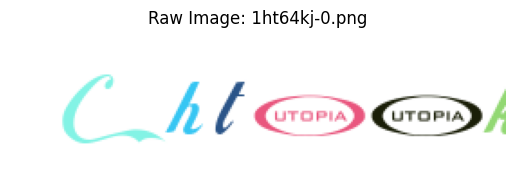

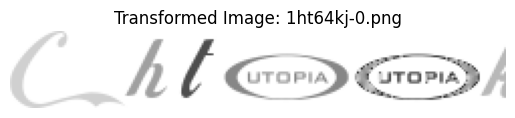

2024-11-13 18:01:53,390 - INFO - Processing file: 1ht64kj-0.png
2024-11-13 18:01:53,396 - INFO - Deskewed image by -90.00 degrees.
2024-11-13 18:01:53,399 - WARNING - Detected regions: 0, Expected: 7
2024-11-13 18:01:53,399 - WARNING - Segmentation failed for 1ht64kj-0.png.
2024-11-13 18:01:53,400 - INFO - Applying fallback segmentation for 1ht64kj-0.png.
2024-11-13 18:01:53,415 - INFO - Saved character '1' to ./dataset/train_segments/1/1_c61e4e7827c243a78176b1e2c06f9dba.png using fallback.
2024-11-13 18:01:53,423 - INFO - Saved character 'h' to ./dataset/train_segments/h/h_f27bd35143c64a77b63d87ef5e80be12.png using fallback.
2024-11-13 18:01:53,426 - INFO - Saved character 't' to ./dataset/train_segments/t/t_3cf4bdcb9a7141fba6c35551e41b44f8.png using fallback.
2024-11-13 18:01:53,462 - INFO - Saved character '6' to ./dataset/train_segments/6/6_45ce556a6ff04ba7b22589693cde1792.png using fallback.
2024-11-13 18:01:53,503 - INFO - Saved character '4' to ./dataset/train_segments/4/4_0eddb

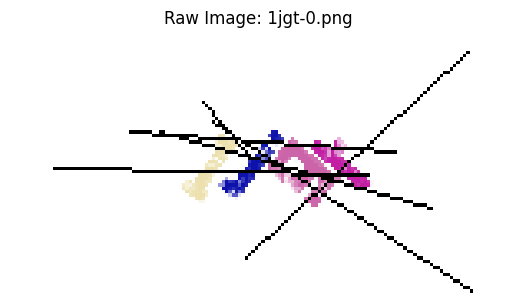

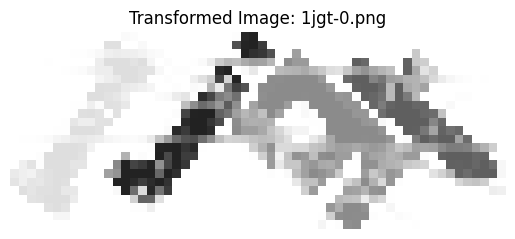

2024-11-13 18:01:53,668 - INFO - Processing file: 1jgt-0.png
2024-11-13 18:01:53,669 - INFO - Deskewed image by -90.00 degrees.
2024-11-13 18:01:53,670 - WARNING - Detected regions: 0, Expected: 4
2024-11-13 18:01:53,670 - WARNING - Segmentation failed for 1jgt-0.png.
2024-11-13 18:01:53,671 - INFO - Applying fallback segmentation for 1jgt-0.png.
2024-11-13 18:01:53,671 - INFO - Saved character '1' to ./dataset/train_segments/1/1_60ae8b94f6df40b7a98a614460bd905a.png using fallback.
2024-11-13 18:01:53,672 - INFO - Saved character 'j' to ./dataset/train_segments/j/j_66854984017345dc97631629d056e8d0.png using fallback.
2024-11-13 18:01:53,673 - INFO - Saved character 'g' to ./dataset/train_segments/g/g_4b8f5a9fdeb341d7bc1981a26a12a5fd.png using fallback.
2024-11-13 18:01:53,674 - INFO - Saved character 't' to ./dataset/train_segments/t/t_6ec91857e7f74661ae171e978ee71a33.png using fallback.
2024-11-13 18:01:53,674 - INFO - Fallback segmentation completed for 1jgt-0.png.


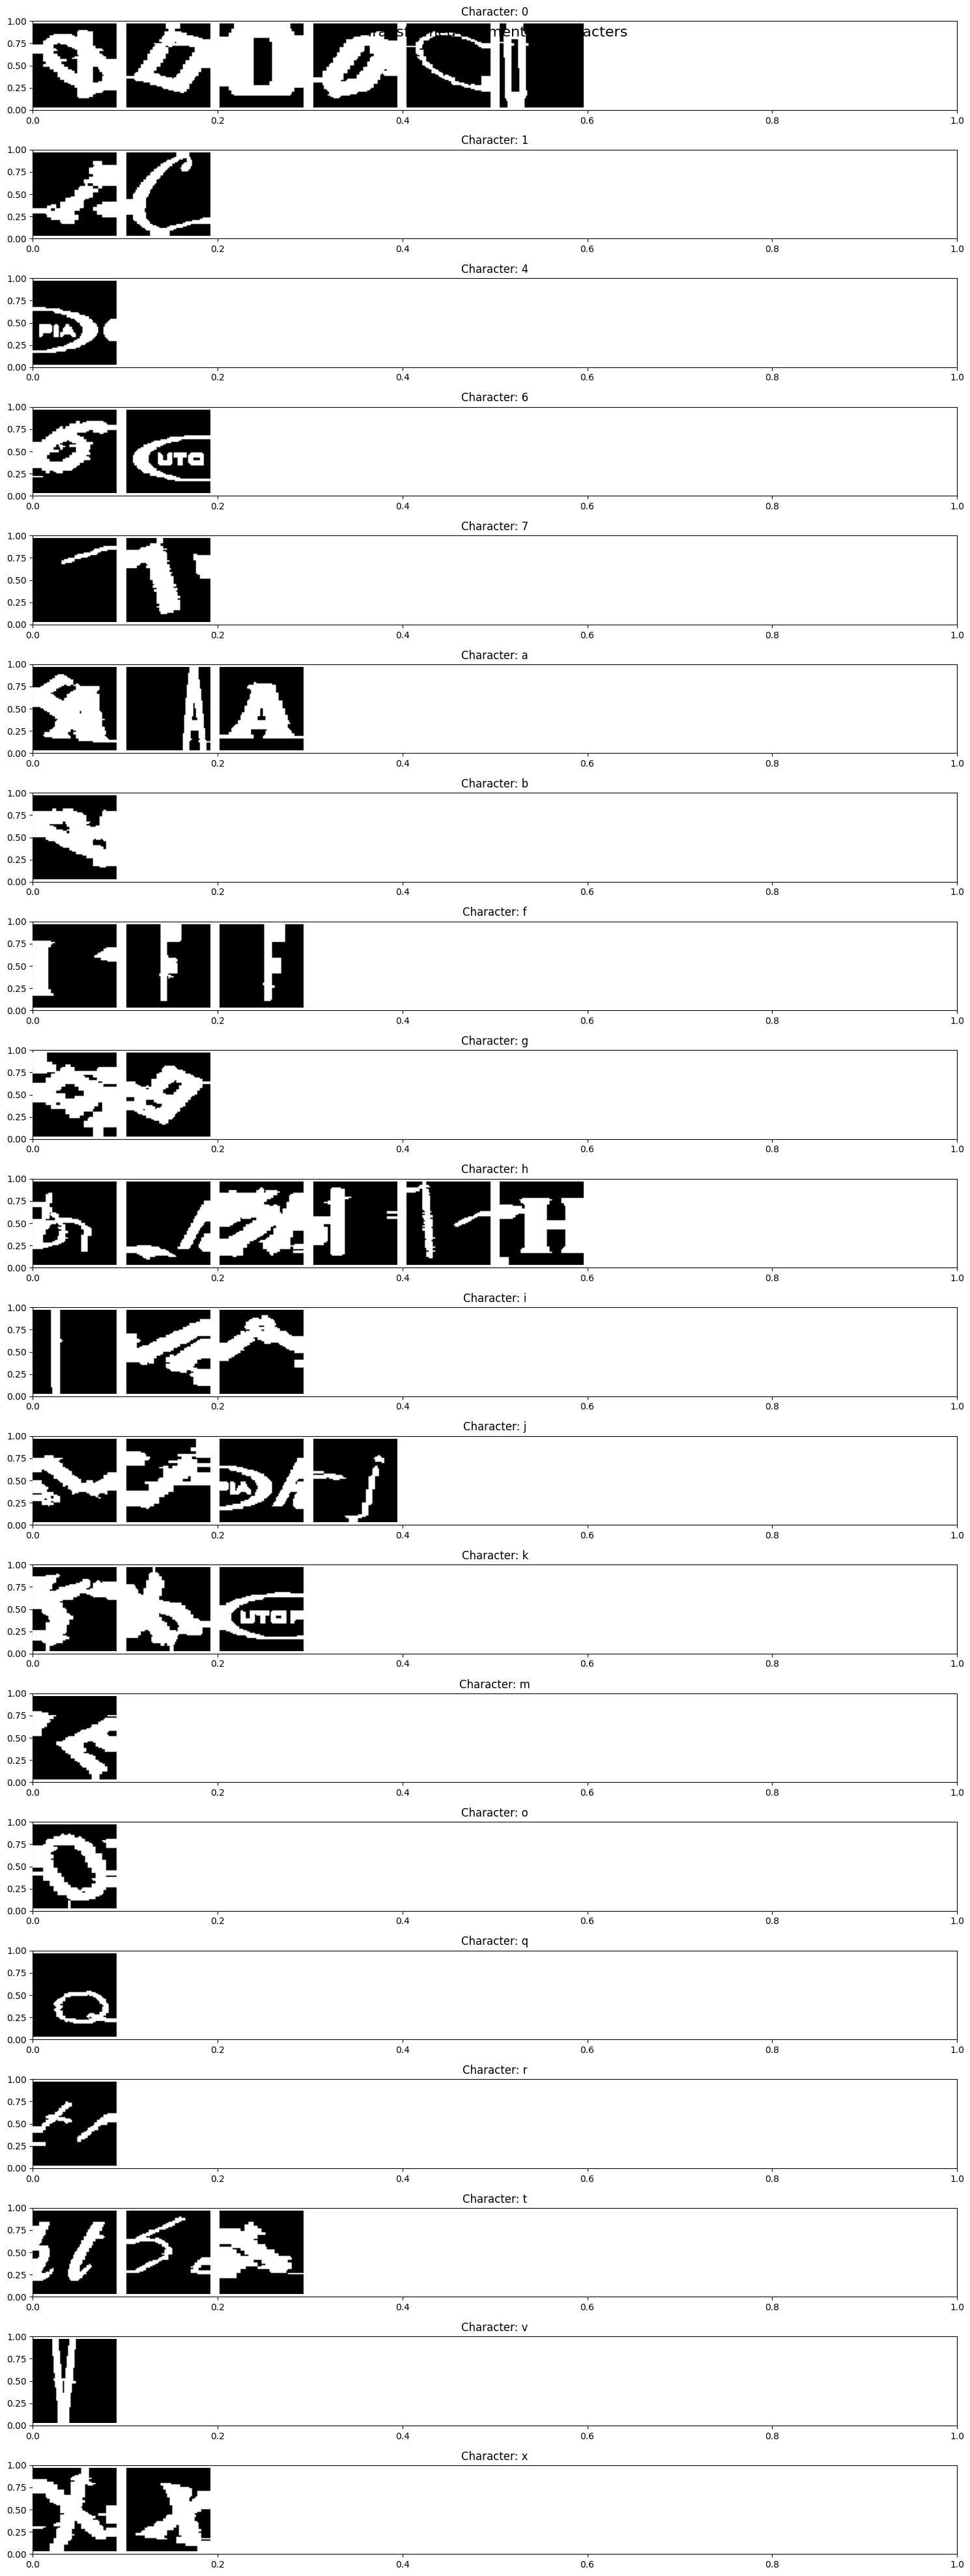

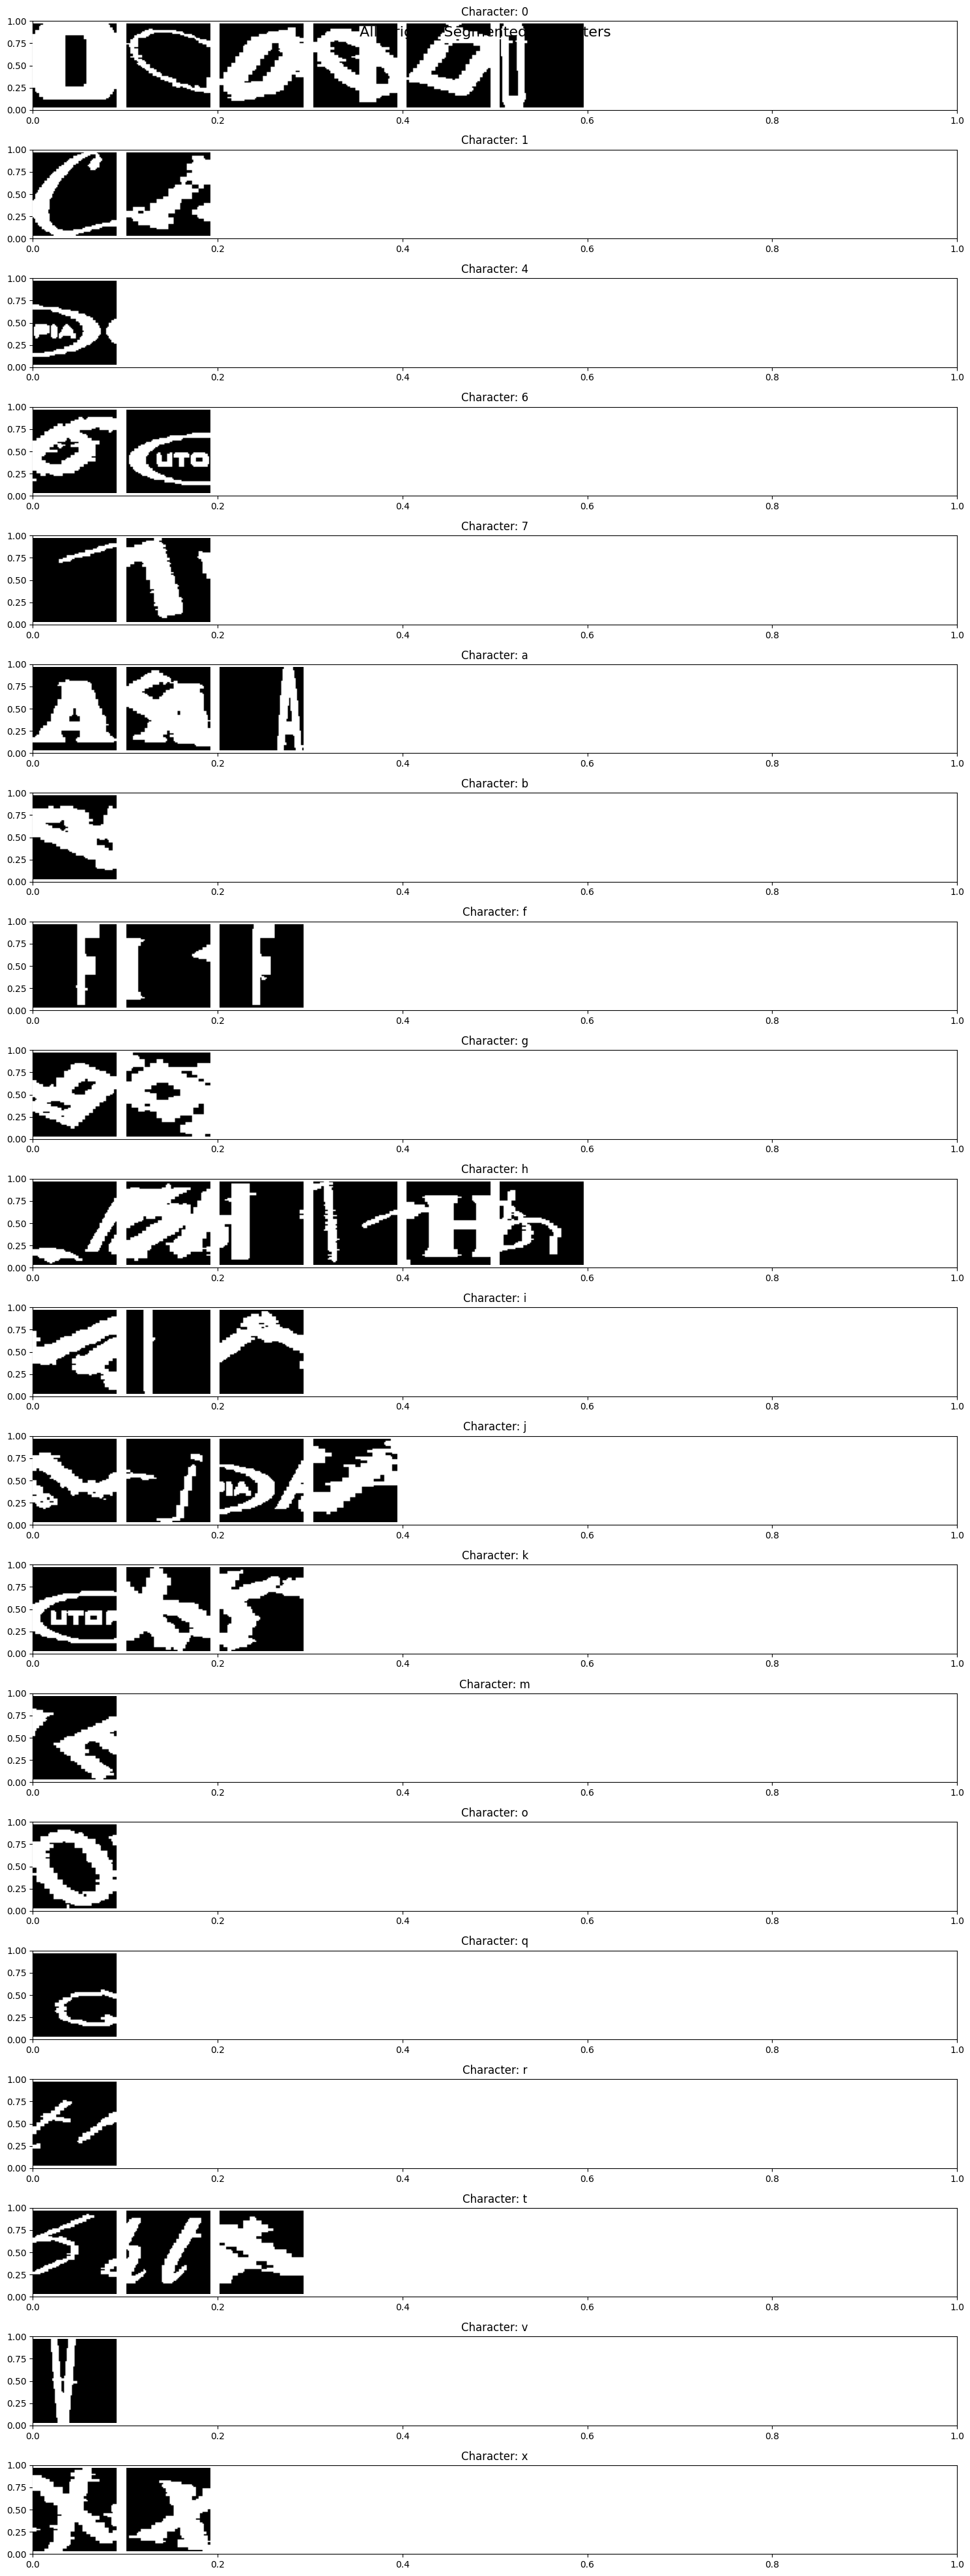

In [117]:
# Hardcode the test set of images from /train
import matplotlib.pyplot as plt
import shutil

test_images = [
    # "hz3y-0.png",
    # "0a1gfi-0.png",
    # "0a4y-0.png",
    "0axhfa-0.png",  # difficult
    "0h7htrjq-0.png",  # difficult
    "0hox6-0.png",  # difficult
    "0ihk7bk-0.png",
    "0ivffa-0.png",
    "0mjig-0.png",  # overlap
    "1ht64kj-0.png",  # mask
    "1jgt-0.png",  # overlap
]

# Clear the train_segments and train_segments_original folders
segments_path = "./dataset/train_segments/"
segments_original_path = "./dataset/train_segments_original/"
for path in [segments_path, segments_original_path]:
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

# Copy the test images to the test_chars_path and apply transformations
for image in test_images:
    src_path = os.path.join(train_path, image)
    dst_path = os.path.join("train_chars_individually/", image)

    # Check if the file exists before attempting to read
    if os.path.exists(src_path):
        # Read the image
        img = cv2.imread(src_path)

        if img is not None:
            # Display the raw image before transformation
            plt.figure()
            plt.title(f"Raw Image: {image}")
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis("off")  # Hide axes
            plt.show()

            # Apply transformations
            img_transformed = remove_lines(img)
            # img_transformed = remove_watermark(img_transformed)  # Additional cleaning
            img_transformed = crop(img_transformed)
            # img_transformed = preprocess_image(img_transformed)
            # img_transformed = remove_noise(img_transformed)

            # Display the image after transformation
            plt.figure()
            plt.title(f"Transformed Image: {image}")
            plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
            plt.axis("off")  # Hide axes
            plt.show()

            # Save the transformed image
            cv2.imwrite(dst_path, img_transformed)

            # Save the original image to the original segments folder
            filename = os.path.basename(dst_path)
            segment_save(
                img_transformed, filename, destination_path=segments_original_path
            )

            # Save the transformed image to the segments folder
            segment_save_better(
                img_transformed, filename, destination_path=segments_path
            )

        else:
            print(
                f"Warning: Image {image} could not be read. Please check the file path or integrity."
            )
    else:
        print(f"Warning: Image {image} does not exist at path {src_path}.")


# Display all segmented characters from the segments folder
def display_segmented_characters(segments_path, title):
    characters = sorted(os.listdir(segments_path))  # Get all character folders

    plt.figure(figsize=(15, len(characters) * 2))
    plt.suptitle(title, fontsize=16)

    for idx, char in enumerate(characters):
        char_path = os.path.join(segments_path, char)
        if os.path.isdir(char_path):
            # Get all images for this character
            char_images = [f for f in os.listdir(char_path) if f.endswith(".png")]

            if char_images:
                # Create subplot for this character
                plt.subplot(len(characters), 1, idx + 1)
                plt.title(f"Character: {char}")

                # Display up to 10 examples side by side
                for i, img_name in enumerate(char_images[:10]):
                    img_path = os.path.join(char_path, img_name)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                    plt.subplot(len(characters), 10, idx * 10 + i + 1)
                    plt.imshow(img, cmap="gray")
                    plt.axis("off")
                    if i == 0:  # Only show character label for first image in row
                        plt.ylabel(char)

    plt.tight_layout()
    plt.show()


# Display segmented characters from both folders
display_segmented_characters(segments_path, "All Transformed Segmented Characters")
display_segmented_characters(
    segments_original_path, "All Original Segmented Characters"
)

In [119]:
import random
import shutil


## Same set of random images

# ... existing imports ...
import json

# Clear and recreate directories
if os.path.exists(train_chars_path):
    shutil.rmtree(train_chars_path)
os.makedirs(train_chars_path)

if os.path.exists(test_chars_path):
    shutil.rmtree(test_chars_path)
os.makedirs(test_chars_path)

# File paths for saving selected files
train_selection_file = os.path.join(folder_path, "selected_train_files.json")
test_selection_file = os.path.join(folder_path, "selected_test_files.json")

# Get or load training subset
if os.path.exists(train_selection_file):
    with open(train_selection_file, "r") as f:
        train_subset = json.load(f)
else:
    train_files = os.listdir(train_path)
    train_subset = random.sample(train_files, 1000)
    with open(train_selection_file, "w") as f:
        json.dump(train_subset, f)

# Get or load test subset
if os.path.exists(test_selection_file):
    with open(test_selection_file, "r") as f:
        test_subset = json.load(f)
else:
    test_files = os.listdir(test_path)
    test_subset = random.sample(test_files, 200)
    with open(test_selection_file, "w") as f:
        json.dump(test_subset, f)

# Process training subset
for filename in train_subset:
    img = cv2.imread(os.path.join(train_path, filename))
    img = remove_lines(img)
    img = crop(img)
    # segment_save(img, filename, train_chars_path)
    segment_save_better(img, filename, train_chars_path)


# Process test subset
for filename in test_subset:
    img = cv2.imread(os.path.join(test_path, filename))
    img = remove_lines(img)
    img = crop(img)
    # segment_save(img, filename, test_chars_path)
    segment_save_better(img, filename, test_chars_path)

# Print stats
print("Training set statistics:")
num_classes = print_char_stats(train_chars_path)
print("\nTest set statistics:")
print_char_stats(test_chars_path)

# # Wesley Version taking random smaller number of images for testing

# # Clear and recreate directories
# if os.path.exists(train_chars_path):
#     shutil.rmtree(train_chars_path)
# os.makedirs(train_chars_path)

# if os.path.exists(test_chars_path):
#     shutil.rmtree(test_chars_path)
# os.makedirs(test_chars_path)

# # Get random subset of training data
# train_files = os.listdir(train_path)
# train_subset = random.sample(train_files, 200)  # 40 for training

# # Process training subset
# for filename in train_subset:
#     img = cv2.imread(os.path.join(train_path, filename))
#     img = remove_lines(img)
#     img = crop(img)
#     segment_save(img, filename, train_chars_path)

# # Get random subset of test data
# test_files = os.listdir(test_path)
# test_subset = random.sample(test_files, 50)  # 10 for testing

# # Process test subset
# for filename in test_subset:
#     img = cv2.imread(os.path.join(test_path, filename))
#     img = remove_lines(img)
#     img = crop(img)
#     segment_save(img, filename, test_chars_path)

# # Print stats
# print("Training set statistics:")
# num_classes = print_char_stats(train_chars_path)
# print("\nTest set statistics:")
# print_char_stats(test_chars_path)

# # Segment captchas in training data and save to folder
# if not os.path.exists(train_chars_path):
#     os.makedirs(train_chars_path)

# data_files = os.listdir(train_path)

# for filename in data_files:
#     img = cv2.imread(os.path.join(train_path, filename))
#     img = remove_lines(img)
#     img = crop(img)
#     segment_save(img, filename, train_chars_path)

# # Print Stats
# num_classes = print_char_stats(train_chars_path)

# # Segment captchas in test data and save to folder
# if not os.path.exists(test_chars_path):
#     os.makedirs(test_chars_path)

# data_files = os.listdir(test_path)

# for filename in data_files:
#     img = cv2.imread(os.path.join(test_path, filename))
#     img = remove_lines(img)
#     img = crop(img)
#     segment_save(img, filename, test_chars_path)

2024-11-13 18:07:50,668 - INFO - Processing file: 5vwzw-0.png
2024-11-13 18:07:50,670 - INFO - Deskewed image by -90.00 degrees.
2024-11-13 18:07:50,672 - WARNING - Detected regions: 2, Expected: 5
2024-11-13 18:07:50,672 - WARNING - Segmentation failed for 5vwzw-0.png.
2024-11-13 18:07:50,673 - INFO - Applying fallback segmentation for 5vwzw-0.png.
2024-11-13 18:07:50,674 - INFO - Saved character '5' to ./dataset/train_chars/5/5_fc2ee60c21924b12b1b07363e7571635.png using fallback.
2024-11-13 18:07:50,675 - INFO - Saved character 'v' to ./dataset/train_chars/v/v_50021d5d97064ca39b77aae07268de79.png using fallback.
2024-11-13 18:07:50,676 - INFO - Saved character 'w' to ./dataset/train_chars/w/w_8b220111a3c747fcb90e3c8fd119fc20.png using fallback.
2024-11-13 18:07:50,677 - INFO - Saved character 'z' to ./dataset/train_chars/z/z_2a7da991dc9c44bf86b7680a0887a3a6.png using fallback.
2024-11-13 18:07:50,677 - INFO - Saved character 'w' to ./dataset/train_chars/w/w_4755399ac561432b8466862f99

Training set statistics:
Total number of characters: 0
Number of unique classes (characters): 36

Character distribution:

Test set statistics:
Total number of characters: 0
Number of unique classes (characters): 36

Character distribution:


36

## Augmenting Dataset


## Model


#### Initialise Model


In [120]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.callbacks import EarlyStopping

In [121]:
# Init data
train_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
test_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

batch_size = 8  # 32 smaller batch size

train_generator = train_data.flow_from_directory(
    train_chars_path,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
)

test_generator = test_data.flow_from_directory(
    test_chars_path,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
)

Found 1221 images belonging to 36 classes.
Found 315 images belonging to 36 classes.


In [122]:
# Bare bones version
num_classes = 36
input_shape = (64, 64, 1)
model = Sequential(
    [
        Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        # 2nd Convolutional Block
        Conv2D(64, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        # 3rd Convolutional Block
        Conv2D(128, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(128, (1, 1), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        # Fully Connected Block
        Flatten(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)  # 0.002

model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True,  # 5 increase patience
)

/Users/wesley/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Training Model


In [123]:
epochs = 50  # 100 reduce epoch size
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=early_stopping,
)
model.save("captcha-model.keras")

Epoch 1/50


/Users/wesley/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.0316 - loss: 4.6916 - val_accuracy: 0.0063 - val_loss: 4.8893
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.0323 - loss: 4.1463 - val_accuracy: 0.0286 - val_loss: 4.4254
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0640 - loss: 3.8081 - val_accuracy: 0.0444 - val_loss: 4.0069
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.0612 - loss: 3.6761 - val_accuracy: 0.0413 - val_loss: 3.9718
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0680 - loss: 3.5555 - val_accuracy: 0.0603 - val_loss: 3.6219
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.1111 - loss: 3.3632 - val_accuracy: 0.0921 - val_loss: 3.3603
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1112 - loss: 3.3426 - val_accuracy: 0.1365 - val_loss: 3.3192
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.1196 - loss: 3.2592 - val_accuracy: 0.127

#### Evaluation


In [124]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Add more eval metrics here: captcha accuracy

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3988 - loss: 2.3700
Test Accuracy: 41.90%


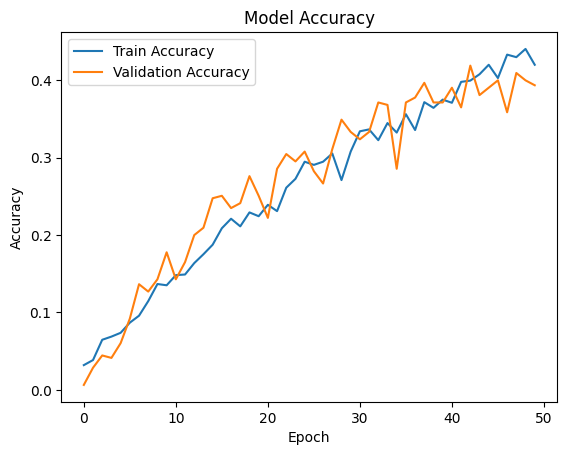

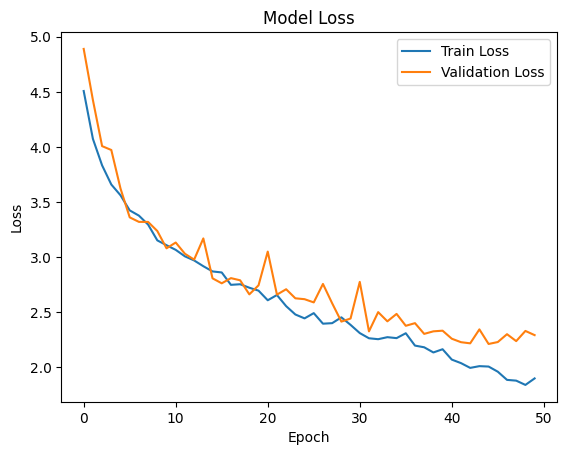

In [125]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.show()

# Plot training & validation loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")
plt.show()